In [1]:
import os
import glob
import pyart
import numpy as np
import xarray as xr
import wradlib as wrl
from datetime import datetime


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [9]:
data_dir = "/Users/syed44/Downloads/SAMA_WORK/data/"
files = glob.glob(os.path.join(data_dir, "RCT*.nc"))
len(files)

1

In [10]:
def read_terls(file=None, outdir=None):
    '''TERLS Mosdac'''
    radar = pyart.io.read_cfradial(file)
    # Just open as simple xarray.Dataset, not decoding times
    vol = xr.open_dataset(file, decode_times=False)
    # 1./2.  fix time unit and time_coverage_start
    start_time = "".join(vol.time_coverage_start.astype(str).values)
    start_time = datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%SZ")
    vol["time_coverage_start"] = start_time
    # time-units is wrong: "seconds since yyyy-mm-ddThh:mm:ssZ"
    vol["time"].attrs["units"] = f"seconds since {start_time}"
    radar.time['units'] = f"seconds since {start_time}"
    # now we can decode time (!)
    vol = xr.decode_cf(vol)
    ele = sorted(list(set(vol.elevation.values) ^ {0}))
    vele = vol.elevation
    sweep_start_ray_index = [vele.where(vele==el).argmin("time").values.item() for el in ele]
    sweep_end_ray_index = [vol.dims["time"] - 
                           vele.where(vele==el)[::-1].argmin("time").values.item() for el in ele]
    # vol["sweep_start_ray_index"].values = sweep_start_ray_index
    # vol["sweep_end_ray_index"].values = sweep_end_ray_index
    radar.sweep_start_ray_index['data'] = np.ma.masked_array(sweep_start_ray_index)
    radar.sweep_end_ray_index['data'] = np.ma.masked_array(sweep_end_ray_index)
    if outdir is None:
        outdir = "CFRADIAL"
    os.makedirs(outdir, exist_ok=True)
    outfile = os.path.join(outdir, os.path.basename(file))
    pyart.io.write_cfradial(outfile, radar=radar)
    print(f"Cfrad saved as {outfile}")
    return None

In [11]:
for file in files:
    read_terls(file=file, outdir="CFRADIAL")

Cfrad saved as CFRADIAL/RCTLS_24JUN2021_045941_L2B_STD.nc


In [13]:
radar = pyart.io.read_cfradial("CFRADIAL/RCTLS_24JUN2021_045941_L2B_STD.nc")

In [14]:
display = pyart.graph.RadarDisplay(radar)

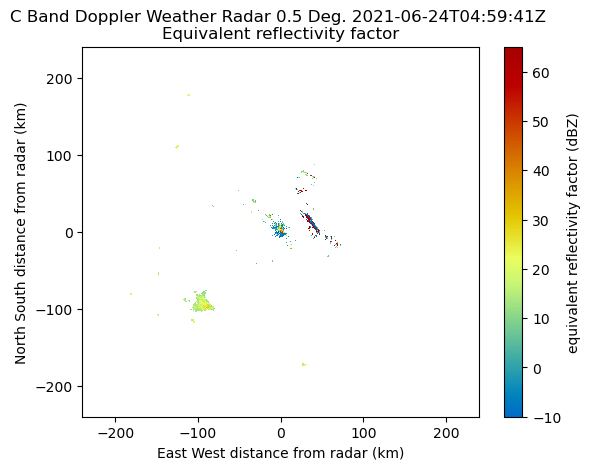

In [15]:
display.plot("DBZ", sweep=0, )

In [16]:
import glob
import pathlib
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import ticker as tick
from osgeo import gdal
import wradlib as wrl
import xradar as xd

In [17]:
fglob = "CFRADIAL/RCTLS_24JUN2021_045941_L2B_STD.nc"
vol = wrl.io.open_cfradial1_dataset(fglob)

/Users/syed44/miniconda3/envs/radar-env/lib/python3.11/site-packages/wradlib/io/netcdf.py:81: FutureWarning: `open_cfradial1_dataset` functionality has been moved to `xradar`-package and will be removed in 2.0. Use `open_cfradial1_datatree` from `xradar`-package.
  return open_radar_dataset(


In [18]:
vol

<wradlib.RadarVolume>
Dimension(s): (sweep: 11)
Elevation(s): (0.5, 1.0, 2.0, 3.0, 4.0, 7.0, 9.0, 12.0, 15.0, 18.0, 21.0)

In [16]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 11)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2021-06-24T04:59:41Z'
    time_coverage_end    <U20 '2021-06-24 05:07:01Z'
    latitude             float64 ...
    longitude            float64 ...
    altitude             float64 ...
    sweep_group_name     (sweep) <U8 'sweep_0' 'sweep_1' ... 'sweep_10'
    sweep_fixed_angle    (sweep) float32 0.5 1.0 2.0 3.0 ... 12.0 15.0 18.0 21.0
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None

In [19]:
from IPython.display import display
swp = vol[0]
display(swp)

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 1600)
Coordinates:
    rtime              (azimuth) datetime64[ns] 2021-06-24T04:59:41.055555555...
  * range              (range) float64 75.0 225.0 375.0 ... 2.398e+05 2.399e+05
  * azimuth            (azimuth) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    elevation          (azimuth) float32 ...
    sweep_mode         <U20 'azimuth surveillance'
    latitude           float64 ...
    longitude          float64 ...
    altitude           float64 ...
    time               datetime64[ns] 2021-06-24T04:59:41.055555555
Data variables:
    DBZ                (azimuth, range) float32 ...
    VEL                (azimuth, range) float32 ...
    WIDTH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    RHOHV              (azimuth, range) float32 ...
    sweep_number       int32 ...
    sweep_fixed_angle  float32 0.5

In [20]:
vol[0]

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 1600)
Coordinates:
    rtime              (azimuth) datetime64[ns] 2021-06-24T04:59:41.055555555...
  * range              (range) float64 75.0 225.0 375.0 ... 2.398e+05 2.399e+05
  * azimuth            (azimuth) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    elevation          (azimuth) float32 ...
    sweep_mode         <U20 'azimuth surveillance'
    latitude           float64 ...
    longitude          float64 ...
    altitude           float64 ...
    time               datetime64[ns] 2021-06-24T04:59:41.055555555
Data variables:
    DBZ                (azimuth, range) float32 ...
    VEL                (azimuth, range) float32 ...
    WIDTH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    RHOHV              (azimuth, range) float32 ...
    sweep_number       int32 ...
    sweep_fixed_angle  float32 0.5

In [21]:
# Number of azimuths (rays)
swp["azimuth"].count()

<xarray.DataArray 'azimuth' ()>
array(360)
Coordinates:
    sweep_mode  <U20 'azimuth surveillance'
    latitude    float64 ...
    longitude   float64 ...
    altitude    float64 ...
    time        datetime64[ns] 2021-06-24T04:59:41.055555555

In [22]:
# Elevations
vol.root.sweep_fixed_angle.values

array([ 0.5,  1. ,  2. ,  3. ,  4. ,  7. ,  9. , 12. , 15. , 18. , 21. ],
      dtype=float32)

In [24]:
swp.azimuth.shape, swp.range.shape

((360,), (1600,))

In [25]:
nrays = 360
nbins = 1600
range_res = 150
ranges = np.arange(nbins) * range_res
elevs = vol.root.sweep_fixed_angle.values
sitecoords = (
    vol.root.longitude.values.item(),
    vol.root.latitude.values.item(),
    vol.root.altitude.values.item(),
)

beamwidth = 1.0 # this is unfortunately not in the volume, we need to know this from somewhere else

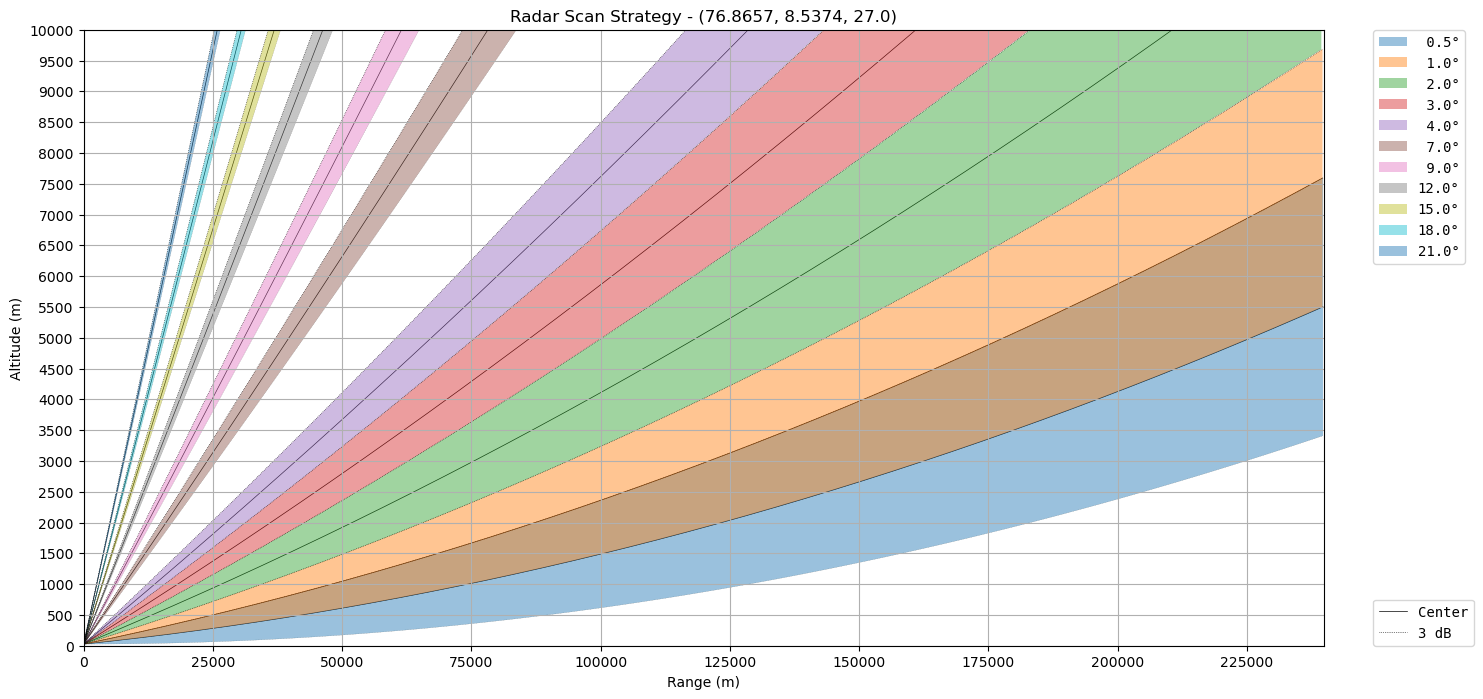

In [26]:
ax = wrl.vis.plot_scan_strategy(ranges, elevs, sitecoords)

In [27]:
sitecoords

(76.8657, 8.5374, 27.0)

Go to https://urs.earthdata.nasa.gov/profile, and click generate token, and paste it here in ""

In [28]:
import os
os.environ["WRADLIB_EARTHDATA_BEARER_TOKEN"] = ""
os.environ["WRADLIB_DATA"] = "./"

In [29]:
swp.longitude.values, swp.latitude.values

(array(76.8657), array(8.5374))

In [32]:
(swp.range.max()/1e3).values

array(239.925)

In [33]:
fdem = glob.glob("./*tif")[0]

In [34]:
el = swp.sweep_fixed_angle.values
bw = 0.9  # half power beam width (deg)
range_res = (swp.range[1] - swp.range[0]).values

In [35]:
coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
coords = wrl.georef.spherical_to_proj(
    coord[..., 0], coord[..., 1], coord[..., 2], sitecoords
)
lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]

In [37]:
rlimits = (lon.min(), lat.min(), lon.max(), lat.max())
print(
    "Radar bounding box:\n\t%.2f\n%.2f             %.2f\n\t%.2f"
    % (lat.max(), lon.min(), lon.max(), lat.min())
)

Radar bounding box:
	10.71
74.69             79.04
	6.37


In [39]:
polcoords = coords[..., :2]
print("lon,lat,alt:", coords.shape)

lon,lat,alt: (360, 1600, 3)


In [52]:
ds = wrl.io.open_raster(fdem)
rastervalues, rastercoords, crs = wrl.georef.extract_raster_dataset(ds)
# Clip the region inside our bounding box
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1] : ind[3], ind[0] : ind[2], ...]
rastervalues = rastervalues[ind[1] : ind[3], ind[0] : ind[2]]

In [41]:
elevation = wrl.georef.read_gdal_values(ds)
coords = wrl.georef.read_gdal_coordinates(ds)

In [42]:
elev = xr.DataArray(
    data=elevation,
    dims=["y", "x"],
    coords={"lat": (["y", "x"], coords[..., 1]), "lon": (["y", "x"], coords[..., 0])},
)
elev

<xarray.DataArray (y: 1929, x: 2061)>
array([[  0,   0,   0, ..., 100, 102, 102],
       [  0,   0,   0, ..., 102, 103, 103],
       [  0,   0,   0, ..., 102, 102, 101],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int16)
Coordinates:
    lat      (y, x) float64 9.608 9.608 9.608 9.608 ... 8.001 8.001 8.001 8.001
    lon      (y, x) float64 76.24 76.24 76.24 76.24 ... 77.95 77.95 77.95 77.95
Dimensions without coordinates: y, x

In [43]:
def extract_clutter(da, wsize=5, thrsnorain=0, tr1=6.0, n_p=6, tr2=1.3, rm_nans=False):
    return xr.apply_ufunc(
        wrl.clutter.filter_gabella,
        da,
        input_core_dims=[["azimuth", "range"]],
        output_core_dims=[["azimuth", "range"]],
        dask="parallelized",
        kwargs=dict(
            wsize=wsize,
            thrsnorain=thrsnorain,
            tr1=tr1,
            n_p=n_p,
            tr2=tr2,
            rm_nans=rm_nans,
        ),
    )

In [44]:
swp = vol[0].pipe(wrl.georef.georeference_dataset)
clmap = swp.DBZ.pipe(
    extract_clutter, wsize=5, thrsnorain=0.0, tr1=21.0, n_p=23, tr2=1.3, rm_nans=False
)
swp = swp.assign({"CMAP": clmap})
display(swp)

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 1600)
Coordinates: (12/15)
    rtime              (azimuth) datetime64[ns] 2021-06-24T04:59:41.055555555...
  * range              (range) float64 75.0 225.0 375.0 ... 2.398e+05 2.399e+05
  * azimuth            (azimuth) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    elevation          (azimuth) float32 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.0
    sweep_mode         <U20 'azimuth surveillance'
    latitude           float64 8.537
    ...                 ...
    x                  (azimuth, range) float64 -3.278e-06 ... -4.186e+03
    y                  (azimuth, range) float64 75.0 225.0 ... 2.398e+05
    z                  (azimuth, range) float64 27.65 28.97 ... 3.411e+03
    gr                 (azimuth, range) float64 75.0 225.0 ... 2.399e+05
    rays               (azimuth, range) float32 0.5 0.5 0.5 0.5 ... 0.0 0.0 0.0
    bins               (azimuth, range) float64 75.0 225.0 ... 2.399e+05
Data variables:
    DBZ                (azimuth, range) float32 nan nan 42.0 ... nan nan nan
    VEL                (azimuth, range) float32 ...
    WIDTH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    RHOHV              (azimuth, range) float32 ...
    sweep_number       int32 ...
    sweep_fixed_angle  float32 0.5
    CMAP               (azimuth, range) bool False False False ... False False

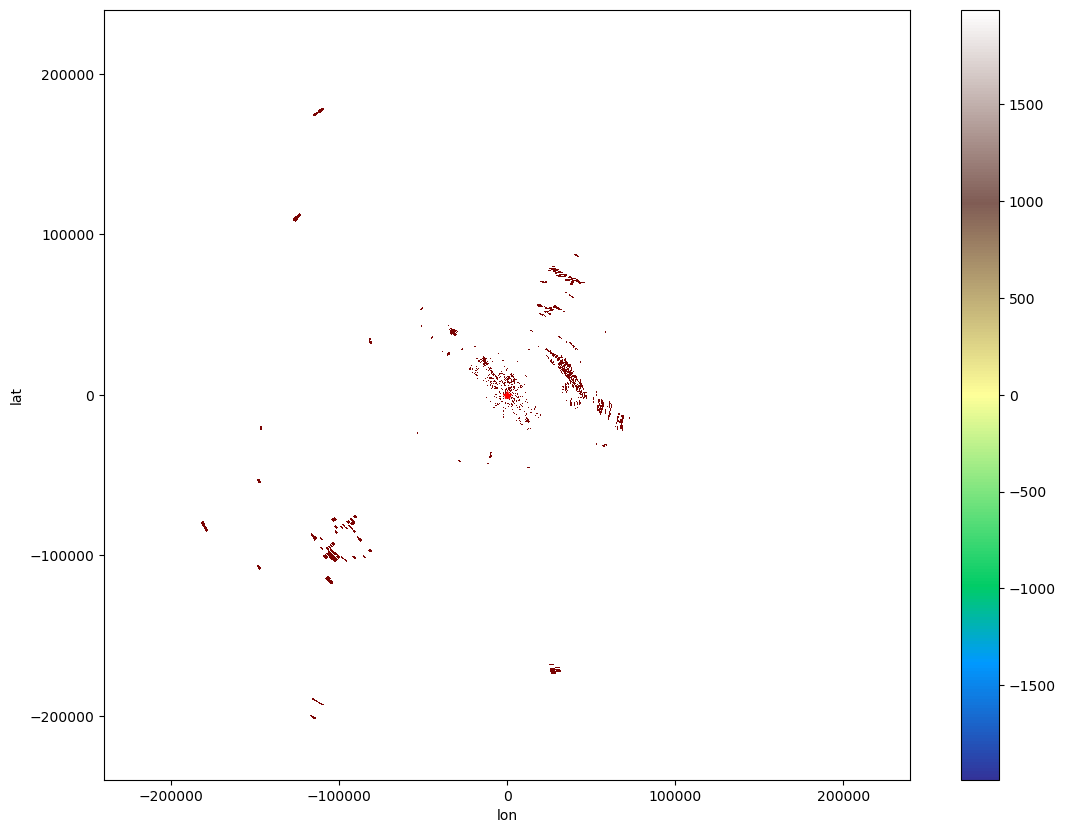

In [45]:
fig = plt.figure(figsize=(13, 10))
ax1 = fig.add_subplot(111)

swp.CMAP.where(swp.CMAP == 1).plot(
    x="x", y="y", ax=ax1, vmin=0, vmax=1, cmap="turbo", add_colorbar=False
)
ax1.set_title("Reflectivity corr")

ax1.plot(swp.longitude.values, swp.latitude.values, marker="*", c="r")

elev.plot(x="lon", y="lat", ax=ax1, zorder=-2, cmap="terrain")

In [243]:
!mamba install hvplot datashader --yes


Looking for: ['hvplot', 'datashader']

conda-forge/osx-arm64                                       Using cache
conda-forge/noarch                                          Using cache
[+] 0.0s
[+] 0.1s
pkgs/main/osx-arm64 ━━━━━━━━━╸━━━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s
pkgs/main/noarch    ━━━━━━━━━━━━━━╸━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s
pkgs/r/osx-arm64    ━━━━━━━━━╸━━━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s
pkgs/r/noarch       ╸━━━━━━━━━━━━━━━╸━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1spkgs/main/noarch                                              No change
pkgs/main/osx-arm64                                           No change
pkgs/r/osx-arm64                                              No change
pkgs/r/noarch                                                 No change

Pinned packages:
  - python 3.11.*


Transaction

  Prefix: /Users/syed44/miniconda3/envs/radar-env

  Updating specs:

   - hvplot
   - datashader
   - ca-certificates
   - certifi
   -

In [46]:
import hvplot
import hvplot.xarray

In [47]:
cl = (
    swp.CMAP.where(swp.CMAP == 1)
    .chunk(chunks={})
    .hvplot.quadmesh(
        x="x", y="y", cmap="Reds", width=800, height=700, clim=(0, 1), alpha=0.6
    )
)
dm = elev.hvplot.quadmesh(
    x="lon",
    y="lat",
    cmap="terrain",
    width=800,
    height=700,
    clim=(0, 4000),
    rasterize=True,
)
dm * cl

:DynamicMap   []
   :Overlay
      .Image.I    :Image   [lon,lat]   (value)
      .QuadMesh.I :QuadMesh   [x,y]   (CMAP)

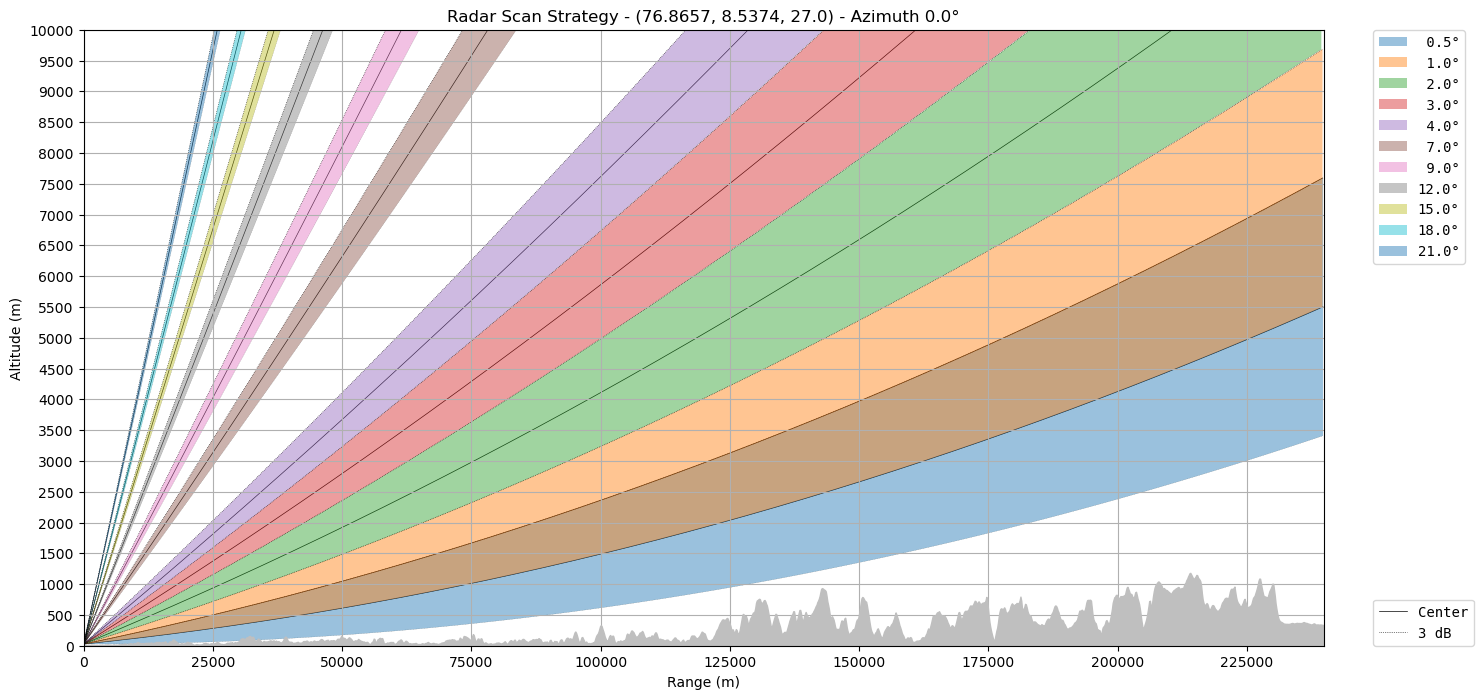

In [170]:
ax = wrl.vis.plot_scan_strategy(ranges, elevs, sitecoords, terrain=True)

If you want to do the basic data quality with pyart

In [171]:
files = glob.glob("CFRADIAL/*.nc")

In [172]:
radar = pyart.io.read(files[0])

In [173]:
radar.fields.keys()

dict_keys(['DBZ', 'VEL', 'WIDTH', 'ZDR', 'PHIDP', 'RHOHV'])

In [181]:
gatefilter = pyart.correct.GateFilter(radar)
gatefilter.exclude_transition()

In [182]:
# # Calculate the Nyquist velocity
# spectral_width = radar.fields['WIDTH']['data']  
# nyquist_velocity = spectral_width / (2.0 * np.sqrt(2.0 * np.log(2)))

In [183]:
# nyquist_velocity_field = pyart.config.get_metadata('nyquist_velocity')
# nyquist_velocity_field['data'] = nyquist_velocity
# nyquist_velocity_field['_FillValue'] = radar.fields['DBZ']['_FillValue']
# radar.instrument_parameters = {'nyquist_velocity':nyquist_velocity_field}

In [184]:
# nyquist_value = nyquist_velocity.mean()

In [185]:
# vel_texture = pyart.retrieve.calculate_velocity_texture(radar,
#                                                         vel_field='VEL',
#                                                         nyq=nyquist_value)

In [186]:
# radar.add_field('texture', vel_texture, replace_existing=True)

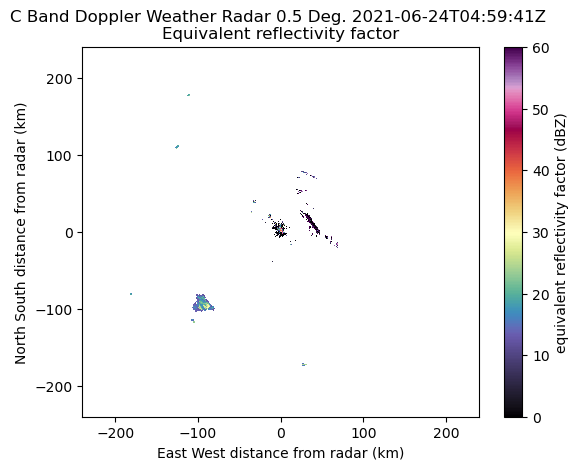

In [187]:
gatefilter = pyart.correct.despeckle_field(radar, 'DBZ', gatefilter=gatefilter)
display = pyart.graph.RadarDisplay(radar)
display.plot('DBZ',
             vmin=0,
             vmax=60, gatefilter=gatefilter,
             cmap='pyart_ChaseSpectral',
             sweep=0)